In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
 
### 0. Data Loading and Labeling Structure - with winter dates
train_tensor = np.load("train_tensor.npy")
validation_tensor = np.load("validation_tensor.npy")

### 0. Data Loading and Labeling Structure - without winter dates
train_tensor_p1 = train_tensor[27:27+299, :, :, :8]
train_tensor_p2 = train_tensor[27+299+67:27+299+67+295, :, :, :8]
train_tensor = np.concatenate((train_tensor_p1, train_tensor_p2), axis=0)
validation_tensor = validation_tensor[26:26+188, :, :, :8]

T = 1  # Number of time steps to look back
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

# Data Preparation

In [5]:
def standardizing_tensor(tensor):
    tensor = tensor.copy()
    stored_means = np.zeros((tensor.shape[0], tensor.shape[3]))
    stored_stds = np.zeros((tensor.shape[0], tensor.shape[3]))
    # Standardize per time step and per channel over all spatial locations (ignoring NaNs)
    for t in range(tensor.shape[0]):
        for c in range(tensor.shape[3]):
            slice_ = tensor[t, :, :, c]
            mean = np.nanmean(slice_)
            std = np.nanstd(slice_)
            if not np.isfinite(std) or std == 0:
                continue
            tensor[t, :, :, c] = (slice_ - mean) / std
            stored_means[t, c] = mean
            stored_stds[t, c] = std
    return tensor, stored_means, stored_stds

def unstandardize_with_stats(tensor_standardized, means, stds):
    # Invert standardization using the same stats; skip invalid stds
    tensor = tensor_standardized.copy()
    T, H, W, C = tensor.shape
    for t in range(T):
        for c in range(C):
            std = stds[t, c]
            if not np.isfinite(std) or std == 0:
                continue
            tensor[t, :, :, c] = tensor[t, :, :, c] * std + means[t, c]
    return tensor

# Apply the updated function
train_tensor, train_means, train_stds = standardizing_tensor(train_tensor)
validation_tensor, validation_means, validation_stds = standardizing_tensor(validation_tensor)

In [6]:
def create_shifted_frames(data, T, target_channels):
    N, H, W, C = data.shape
    n_samples = N - T

    x = np.zeros((n_samples, T, H, W, C), dtype=np.float32)
    y = np.zeros((n_samples, H, W, target_channels), dtype=np.float32)

    for i in range(n_samples):
        x[i] = data[i:i + T]
        y[i] = data[i + T, :, :, :target_channels]
    return x, y

x_train, y_train = create_shifted_frames(train_tensor, T, target_channels=8)
x_val, y_val_true = create_shifted_frames(validation_tensor, T, target_channels=8)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val_true shape: {y_val_true.shape}")

x_train shape: (593, 1, 63, 173, 8)
y_train shape: (593, 63, 173, 8)
x_val shape: (185, 1, 63, 173, 8)
y_val_true shape: (185, 63, 173, 8)


# Model & Training

In [7]:
### 1. Model Architecture
def create_model(train_tensor):
    print("\nCreating ConvLSTM model:")
    x_train, y_train = create_shifted_frames(train_tensor, T, target_channels=8)
    x_val, y_val = create_shifted_frames(validation_tensor, T, target_channels=8)

    inputs = keras.Input(shape=(T, train_tensor.shape[1], train_tensor.shape[2], 8))

    x = layers.ConvLSTM2D(filters=32, 
                          kernel_size=(5,5), 
                          padding="same", 
                          return_sequences=True, 
                          activation="relu"
    )(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.ConvLSTM2D(filters=64,
                          kernel_size= (3,3),
                          padding="same", 
                          return_sequences=True,
                          activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(filters=32,
                          kernel_size=(3,3),
                          padding="same",
                          return_sequences=False,
                          activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Conv2D(filters=8, kernel_size=(1, 1), activation="linear")(x)
    return keras.Model(inputs, outputs)
model = create_model(train_tensor)

#model.compile(optimizer="adam", loss=masked_mse(spatial_mask), metrics=["mae"])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

### 2. Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val_true), epochs=10, batch_size=8)


Creating ConvLSTM model:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 63, 173, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 63, 173, 32) │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 63, 173, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 63, 173, 64) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 63, 173, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 63, 173, 32)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 173, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 63, 173, 8)     │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,064 (1.76 MB)

 Trainable params: 460,808 (1.76 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - loss: 0.6785 - mae: 0.4333 - val_loss: 0.9656 - val_mae: 0.6023
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - loss: 0.2226 - mae: 0.2363 - val_loss: 0.8831 - val_mae: 0.5705
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.1933 - mae: 0.2165 - val_loss: 0.7029 - val_mae: 0.4957
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - loss: 0.1942 - mae: 0.2118 - val_loss: 0.4912 - val_mae: 0.4039
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - loss: 0.1766 - mae: 0.2017 - val_loss: 0.3225 - val_mae: 0.3261
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - loss: 0.1824 - mae: 0.2022 - val_loss: 0.2326 - val_mae: 0.2580
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - loss: 0.1712 - mae: 0.1938 - val_loss: 0.1938 - val_mae: 0.2156
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - loss: 0.1683 - mae: 0.1887 - val_loss: 0.1903 - val_mae: 0.2163
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - loss: 0.1741 - m

In [ ]:
### 3. Inference: Evaluate full validation set
# val_loss, val_mae = model.evaluate(x_val, y_val_true)
# print(f"Validation loss: {val_loss}")
# print(f"Validation MAE: {val_mae}")

y_val_pred = model.predict(x_val)
y_val_true = y_val_true[T:, :, :, :8]  # Ensure y_val_true has the same shape as y_val_pred
y_val_pred = y_val_pred[T:, :, :, :8]  # Ensure y_val_pred has the same shape as y_val_true
print(f"y_val_true shape: {y_val_true.shape}")
print(f"y_val_pred shape: {y_val_pred.shape}")

y_val_pred = unstandardize_with_stats(y_val_pred, validation_means, validation_stds)
y_val_true = unstandardize_with_stats(y_val_true, validation_means, validation_stds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.1749 - mae: 0.1986
Validation loss: 0.1814575046300888
Validation MAE: 0.19988609850406647
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
y_val_true shape: (184, 63, 173, 8)
y_val_pred shape: (184, 63, 173, 8)


# Validation

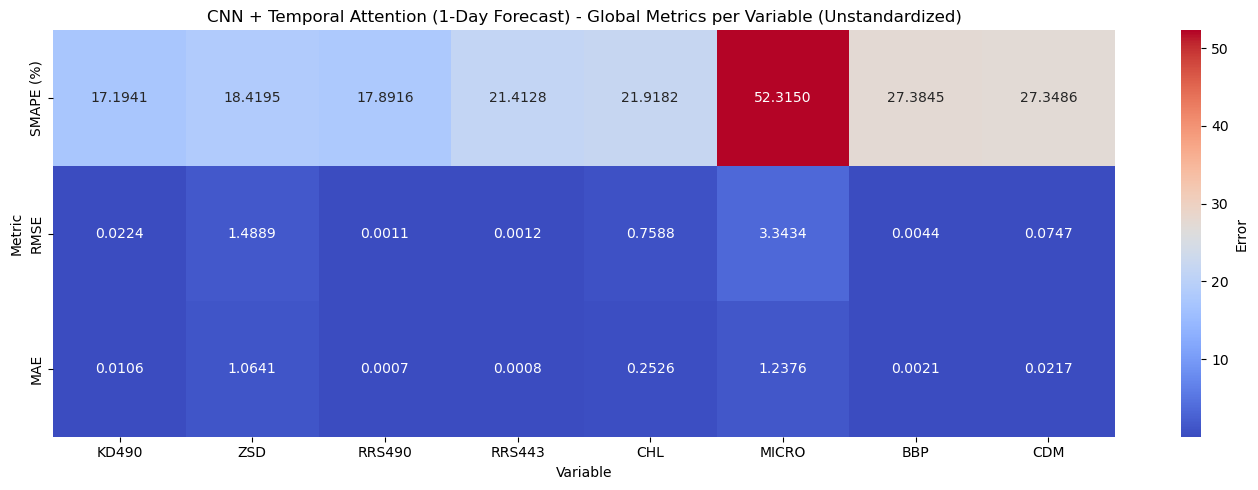

In [9]:
### 4. Evaluation
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

eps = 1e-8
smape = 100 * np.mean(
    np.abs(y_val_pred - y_val_true) /
    (np.abs(y_val_pred) + np.abs(y_val_true) + eps),
    axis=(0, 1, 2)
)
rmse = np.sqrt(np.mean((y_val_pred - y_val_true) ** 2, axis=(0, 1, 2)))
mae  = np.mean(np.abs(y_val_pred - y_val_true), axis=(0, 1, 2))


# Build DataFrame

metrics_df = pd.DataFrame({
    'SMAPE (%)': smape,
    'RMSE': rmse,
    'MAE': mae
}, index=features).T  # transpose to match your heatmap format


# Plot heatmap

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("CNN + Temporal Attention (1-Day Forecast) - Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

First date: 2024-01-31
Last date: 2024-08-05


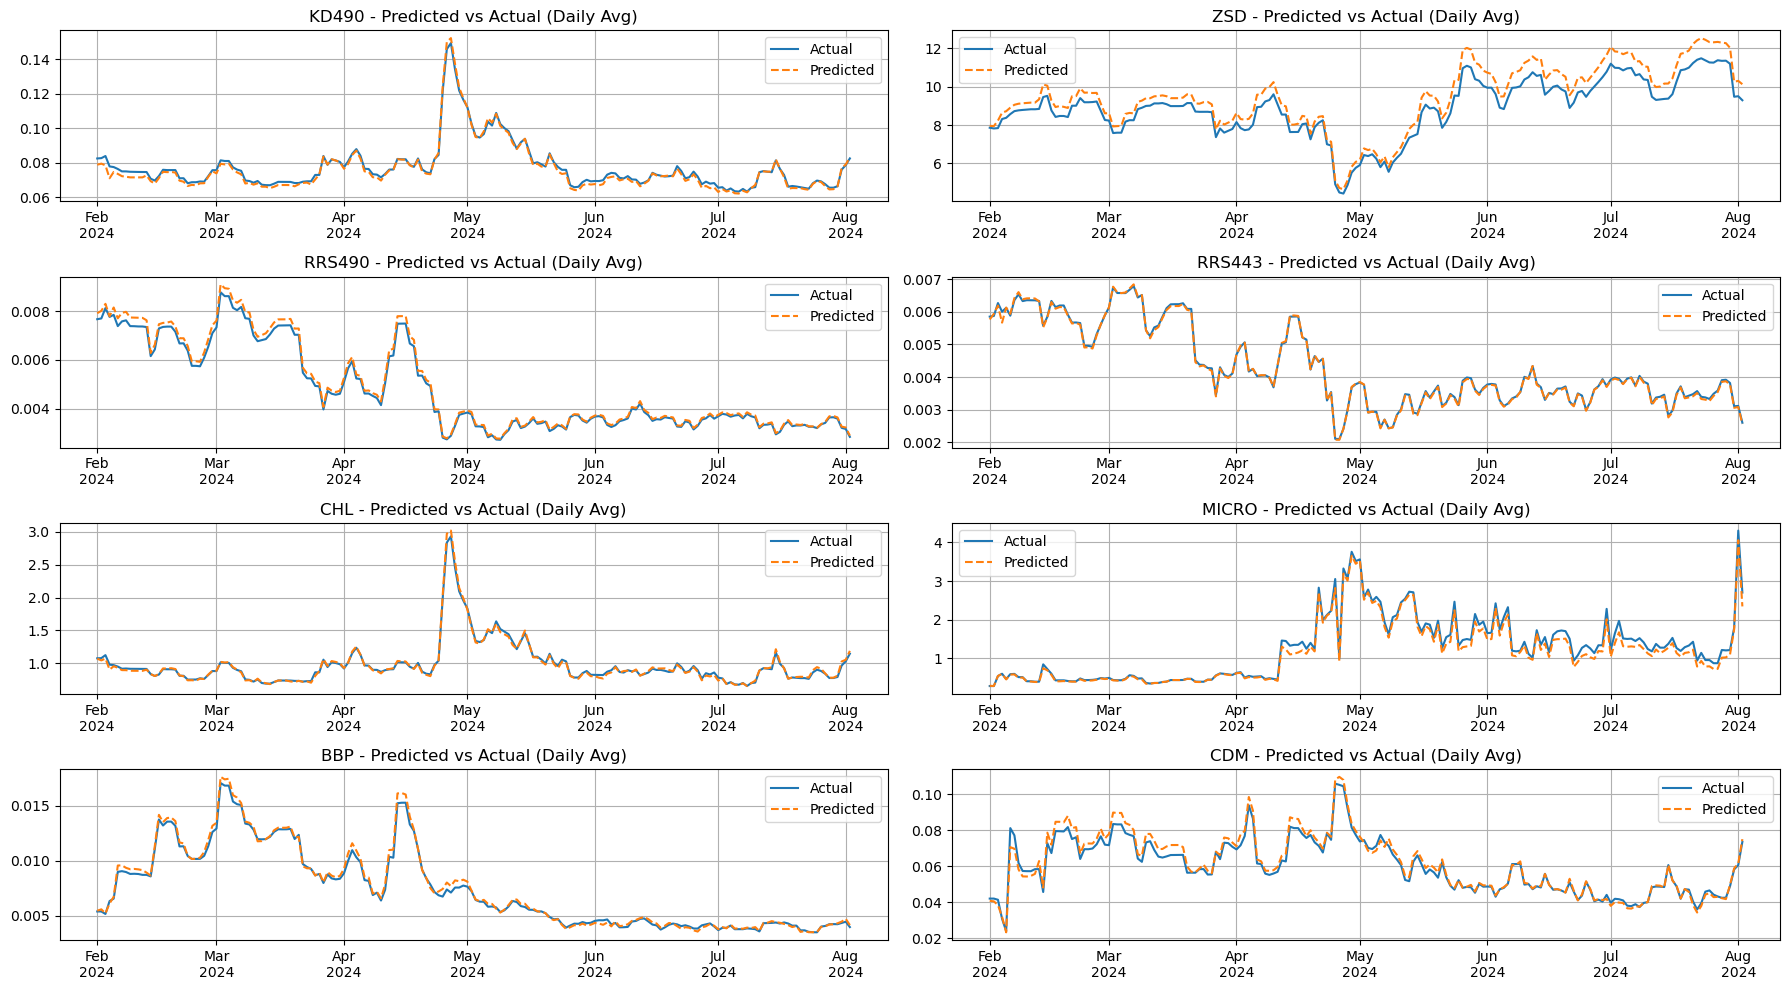

In [10]:
import datetime

start_date = datetime.date(2024, 1, 1)
first_index = 30
last_index = 30 + 188 - 1  # 211 - 1 = 210

first_date = start_date + datetime.timedelta(days=first_index)
last_date = start_date + datetime.timedelta(days=last_index)
val_dates = [first_date + datetime.timedelta(days=i) for i in range((last_date - first_date).days + 1)]

print("First date:", first_date)
print("Last date:", last_date)

# Daily spatial means plot

seq_len = 1  # or whatever your model uses

pred_means = y_val_pred.mean(axis=(1, 2)) 
#true_means = y_val_true.mean(axis=(1, 2))
val_dates_seq = val_dates[seq_len: seq_len + len(pred_means)]

import matplotlib.dates as mdates
fig, axs = plt.subplots(4, 2, figsize=(18, 10)); axs = axs.flatten()
for i, var in enumerate(features):
    valid = y_val_true[:, :, :, i] != 0
    actual = np.where(valid, y_val_true[:, :, :, i], np.nan)
    true_means = np.nanmean(actual, axis=(1, 2))
    axs[i].plot(val_dates_seq, true_means, label="Actual")
    axs[i].plot(val_dates_seq, pred_means[:, i], label="Predicted", linestyle="--")
    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg)")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True); axs[i].legend()
plt.tight_layout(); plt.show()

# Testing

In [11]:
test_tensor = np.load("test_tensor.npy")

test_tensor, test_means, test_stds = standardizing_tensor(test_tensor)

x_test, y_test_true = create_shifted_frames(test_tensor, T, target_channels=8)
y_test_pred = model.predict(x_test)
y_test_true = y_test_true[T:, :, :, :8]  # Ensure y_test
y_test_pred = y_test_pred[T:, :, :, :8]  # Ensure y_test_pred has the same shape as y_test_true
y_test_pred = unstandardize_with_stats(y_test_pred, test_means, test_stds)
y_test_true = unstandardize_with_stats(y_test_true, test_means, test_stds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


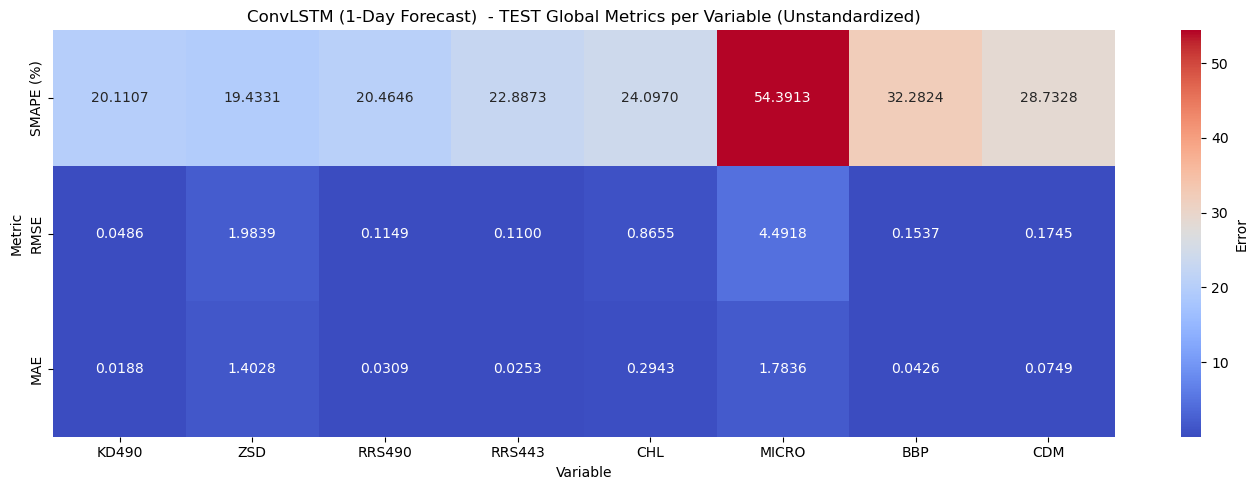

In [14]:
### 4. Evaluation
features = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']

eps = 1e-8
smape = 100 * np.mean(
    np.abs(y_test_pred - y_test_true) /
    (np.abs(y_test_pred) + np.abs(y_test_true) + eps),
    axis=(0, 1, 2)
)
rmse = np.sqrt(np.mean((y_test_pred - y_test_true) ** 2, axis=(0, 1, 2)))
mae  = np.mean(np.abs(y_test_pred - y_test_true), axis=(0, 1, 2))


# Build DataFrame

metrics_df = pd.DataFrame({
    'SMAPE (%)': smape,
    'RMSE': rmse,
    'MAE': mae
}, index=features).T  # transpose to match your heatmap format


# Plot heatmap

plt.figure(figsize=(14,5))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="coolwarm", cbar_kws={'label': 'Error'})
plt.title("ConvLSTM (1-Day Forecast)  - TEST Global Metrics per Variable (Unstandardized)")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

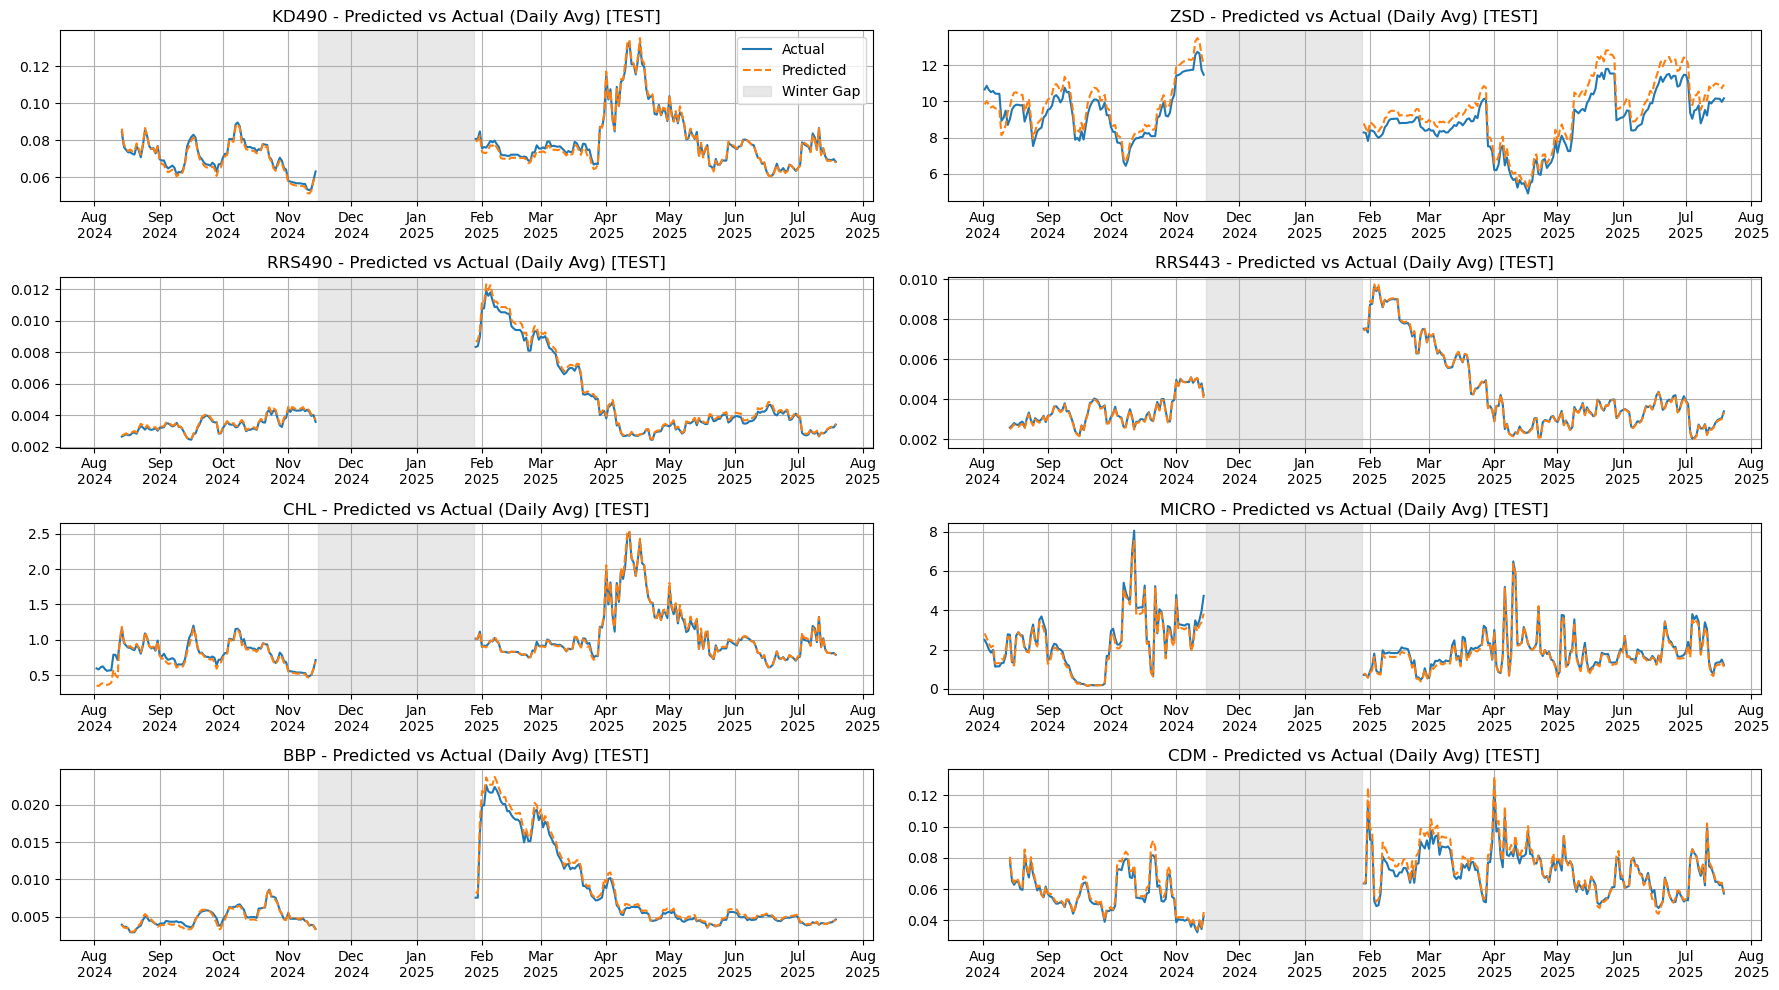

First pred date: 2024-08-02 Last pred date: 2025-07-19


In [15]:
import datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates

seq_len = 1          # your model context
horizon = 1          # 1-step ahead; set 0 if “same-day” labels
S = y_test_pred.shape[0]
F = y_test_pred.shape[1] if y_test_pred.ndim == 2 else y_test_pred.shape[-1]

test_start_date = pd.Timestamp("2024-08-01")

# x-axis dates aligned to TEST predictions
first_pred_date = pd.Timestamp(test_start_date) + pd.Timedelta(days=(seq_len - 1 + horizon))
dates = pd.date_range(start=first_pred_date, periods=S, freq="D")

# daily spatial means
true_means = y_test_true.mean(axis=(1, 2))   # (S, F)
pred_means = y_test_pred.mean(axis=(1, 2))   # (S, F)

# break lines in winter gaps
winter_gaps = [(pd.Timestamp("2024-11-15"), pd.Timestamp("2025-01-28"))]
in_gap = np.zeros(S, dtype=bool)
for s, e in winter_gaps:
    in_gap |= (dates >= s) & (dates <= e)

true_plot = true_means.copy();  pred_plot = pred_means.copy()
true_plot[in_gap, :] = np.nan
pred_plot[in_gap, :] = np.nan

# which variables should be non-negative (default: all)
nonneg_vars = set(features[:F])       # e.g. {"KD490","ZSD","RRS490","RRS443","CHL","MICRO","BBP","CDM"}
eps = 0.0                             # tolerance; use -1e-9 if you have tiny numerical noise
for i, var in enumerate(features[:F]):
    if var not in nonneg_vars:
        continue
    # first index where both true & pred are non-negative
    valid = (true_means[:, i] >= eps) & (pred_means[:, i] >= eps)
    if np.any(valid):
        first_ok = np.argmax(valid)   # first True
        true_plot[:first_ok, i] = np.nan
        pred_plot[:first_ok, i] = np.nan
    else:
        # everything negative → hide entire series to avoid misleading lines
        true_plot[:, i] = np.nan
        pred_plot[:, i] = np.nan

# plot
fig, axs = plt.subplots(4, 2, figsize=(18, 10), sharex=True); axs = axs.ravel()
for i, var in enumerate(features[:F]):
    axs[i].plot(dates, true_plot[:, i], label="Actual")
    axs[i].plot(dates, pred_plot[:, i], ls="--", label="Predicted")
    axs[i].set_title(f"{var} - Predicted vs Actual (Daily Avg) [TEST]")
    axs[i].xaxis.set_major_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axs[i].grid(True)
    for s, e in winter_gaps:
        axs[i].axvspan(s, e, color="lightgrey", alpha=0.5, label="Winter Gap" if i == 0 else None)

# show x-axis date labels on ALL subplots
for ax in axs:
    ax.tick_params(axis="x", which="both", labelbottom=True)
    # (optional) ensure formatter is applied even if sharex hides it
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

axs[0].legend()
plt.subplots_adjust(hspace=0.35)   # a bit more room for the dates
plt.tight_layout()
plt.show()

print("First pred date:", dates[0].date(), "Last pred date:", dates[-1].date())
